In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import numpy as np
from os import listdir
import re

In [17]:
# get all file names
path = 'w_numbers'
files = [f for f in listdir(path) if f[-4:]=='.png']
# load one to get the dimensions
image = mpimg.imread(f'{path}/{files[0]}')
# get dimensions
shape = list(image.shape)
# remove alpha if necessary
if (shape[2]==4):
    shape[2] = 3
n = len(files)
n

10000

In [18]:
y = np.zeros(shape=(n,2),dtype=int)
X = np.zeros(shape=(n,*shape))
for i in range(len(files)):
    # get the hour from the file name
    y[i,0] = re.search('^([0-9]*)_([0-9]*)',files[i])[1]
    y[i,1] = re.search('^([0-9]*)_([0-9]*)',files[i])[2]
    # get the pixels, remove the alpha if needed and convert to 0-255
    X[i] = (mpimg.imread(f'{path}/{files[i]}')[:,:,:shape[2]] )

In [19]:
# transform y to label encoded
temp = y.copy()
y = np.zeros(shape=(n,24),dtype=int)
for i in range(n):
    # hours, 0 to 11 for 1 to 12
    h = temp[i,0] -1
    # minutes 12 to 23 for 0 to 55
    m = temp[i,1]//5 + 12
    y[i,h] = 1
    y[i,m] = 1

4_0_clock_6942.png
4 0
[0 0 0 1 0 0 0 0 0 0 0 0]
[1 0 0 0 0 0 0 0 0 0 0 0]


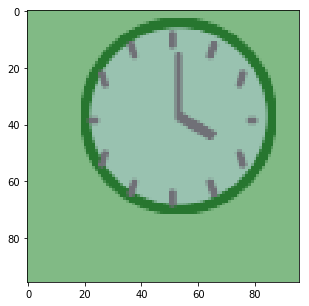

In [20]:
i = np.random.randint(0,n)
print(files[i])
print(temp[i,0],temp[i,1])
print(y[i,:12])
print(y[i,12:])
plt.figure(figsize=(5,5))
plt.imshow(X[i])
plt.show()

In [21]:
p = 0.8
c = int(len(X) * p)

X_train = X[:c]
y_train = y[:c]

X_test = X[c:]
y_test = y[c:]

In [7]:
from keras.models import Model
from keras.layers import Input, Dense, Convolution2D, Flatten, MaxPooling2D, Dropout

Using TensorFlow backend.


In [13]:
input_layer = Input(shape=shape)
conv1 = Convolution2D(36, kernel_size=3,activation='relu')(input_layer)
conv2 = Convolution2D(18, kernel_size=3,activation='relu')(conv1)
pool = MaxPooling2D()(conv2)
hidden = Dense(128,activation='relu')(Flatten()(pool))
drop = Dropout(rate=0.5)(hidden)
output1 = Dense(12, activation='softmax')(drop)
output2 = Dense(12, activation='softmax')(drop)

model = Model(inputs=input_layer, outputs=[output1, output2])
model.compile(optimizer='adam', loss=['categorical_crossentropy', 'categorical_crossentropy'],
              metrics=['accuracy'], loss_weights=[1., 1])

In [53]:
model.save('200319_3.h5')

In [47]:
model.fit(X_train, [y_train[:,:12],y_train[:,12:]],
          epochs=3,
          batch_size=10)

Epoch 1/3
8000/8000 [==============================] - 235s 29ms/step - loss: 1.1951 - dense_11_loss: 0.8615 - dense_12_loss: 0.3336 - dense_11_acc: 0.7023 - dense_12_acc: 0.8777
Epoch 2/3
8000/8000 [==============================] - 252s 32ms/step - loss: 0.9488 - dense_11_loss: 0.6638 - dense_12_loss: 0.2850 - dense_11_acc: 0.7665 - dense_12_acc: 0.8987
Epoch 3/3
8000/8000 [==============================] - 240s 30ms/step - loss: 0.7314 - dense_11_loss: 0.4972 - dense_12_loss: 0.2343 - dense_11_acc: 0.8315 - dense_12_acc: 0.9150


In [48]:
model.evaluate(X_test, [y_test[:,:12],y_test[:,12:]], batch_size=10)

2000/2000 [==============================] - 16s 8ms/step


[0.7916558478772641,
 0.5908825357910246,
 0.20077331411477645,
 0.8079999957978725,
 0.9419999924302102]

(1, 96, 96, 3)


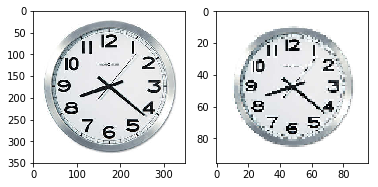

In [49]:
test1 = mpimg.imread('test/imageService.jpeg')

small_test = np.ones([1,96,96,3]) *255
small_test[0,4:-4,4:-4,:] = test1[::4,::4]
small_test/=255

print(small_test.shape)

fig, axes = plt.subplots(ncols=2)
axes[0].imshow(test1)
axes[1].imshow(small_test[0])
plt.show()

In [50]:
np.round(model.predict(small_test),1)

array([[[0. , 0. , 0.1, 0. , 0. , 0. , 0. , 0.1, 0.8, 0. , 0. , 0. ]],

       [[0. , 0. , 0.1, 0.3, 0.4, 0.2, 0. , 0. , 0. , 0. , 0. , 0. ]]],
      dtype=float32)

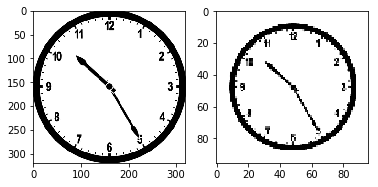

In [51]:
test2 = mpimg.imread('test/nclock-10-25_34219_sm.gif')

reshaped = np.ones((1,96,96,3)) * 255
reshaped[0,8:-8,8:-8,0] = test2[::4,::4]
reshaped[0,8:-8,8:-8,1] = test2[::4,::4]
reshaped[0,8:-8,8:-8,2] = test2[::4,::4]
reshaped/=255

fig, axes = plt.subplots(ncols=2)
axes[0].imshow(test2,cmap='gray')
axes[1].imshow(reshaped[0])
plt.show()

In [52]:
np.round(model.predict(reshaped),1)

array([[[0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 1. , 0. , 0. ]],

       [[0. , 0. , 0. , 0. , 0. , 0.9, 0. , 0. , 0. , 0. , 0.1, 0. ]]],
      dtype=float32)